#### Getting to know the data

In [37]:
import pandas as pd
from IPython.display import Image

df = pd.read_csv('Data/titanic_train.csv',index_col = 'PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
#Missing values
df.drop(['Cabin'],axis=1,inplace=True)
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
df.Embarked.value_counts()
df.Embarked.unique()
df['Embarked'] = df['Embarked'].fillna('S')
df.Embarked.unique()


array(['S', 'C', 'Q'], dtype=object)

In [39]:
# Separate target from predictors
y = df.Survived
X = df.drop(['Survived'], axis=1)

# Divide data into training and validation subsets
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [40]:
# # "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]


In [41]:
# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()


In [42]:
X_train.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
141,female,C,3,28.0,0,2,15.2458
440,male,S,2,31.0,0,0,10.5000
818,male,C,2,31.0,1,1,37.0042
379,male,C,3,20.0,0,0,4.0125
492,male,S,3,21.0,0,0,7.2500


Next, we obtain a list of all of the categorical variables in the training data.

We do this by checking the data type (or dtype) of each column. The object dtype indicates a column has text (there are other things it could theoretically be, but that's unimportant for our purposes). For this dataset, the columns with text indicate categorical variables.

In [43]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Sex', 'Embarked']


## Introduction
A categorical variable takes only a limited number of values.

- Consider a survey that asks how often you eat breakfast and provides four options: "Never", "Rarely", "Most days", or "Every day". In this case, the data is categorical, because responses fall into a fixed set of categories.
- If people responded to a survey about which what brand of car they owned, the responses would fall into categories like "Honda", "Toyota", and "Ford". In this case, the data is also categorical.

You will get an error if you try to plug these variables into most machine learning models in Python without preprocessing them first. In this tutorial, we'll compare three approaches that you can use to prepare your categorical data

## Approches 

There are many approches to deal with categorical data : 
- Drop Categorical Data
- Label Encoding
- One-Hot Encoding
- Dummy Encoding
- Count Encoding
- Target Encoding
- CatBoost Encoding

#### Define Function to Measure Quality of Each Approach
We define a function score_dataset() to compare the three different approaches to dealing with categorical variables. This function reports the mean absolute error (MAE) from a random forest model. In general, we want the MAE to be as low as possible!

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

#### 1 - Drop Categorical Variables
The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.

In [45]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
0.33512789587742187


#### 2 - Label Encoding
Label encoding assigns each unique value to a different integer. 

This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (like decision trees and random forests), you can expect label encoding to work well with ordinal variables.

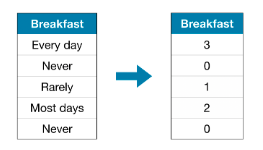

In [46]:
Image(filename='img/Label.png')

In [47]:
from sklearn.preprocessing import LabelEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])

print("MAE from Approach 2 (Label Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Label Encoding):
0.22400101299912342


In [56]:
label_X_train.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
141,0,0,3,28.0,0,2,15.2458
440,1,2,2,31.0,0,0,10.5000
818,1,0,2,31.0,1,1,37.0042
379,1,0,3,20.0,0,0,4.0125
492,1,2,3,21.0,0,0,7.2500


#### One-hot encoding and dummy variables

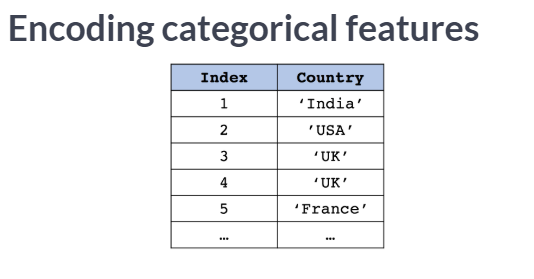

In [13]:
Image(filename='img/cat_feat.png')

To get from qualitative inputs to quantitative features, one may naively think that assigning every category in a column a number would suffice, for example 'India' could be 1, 'USA' 2 etc. But these categories are unordered, so assigning this order may greatly penalize the effectiveness of your model.
Thus, you cannot allocate arbitrary numbers to each category as that would imply some form of ordering in the categories. 

Instead, values can be encoded by creating additional binary features corresponding to whether each value was picked or not as shown in the figure below.

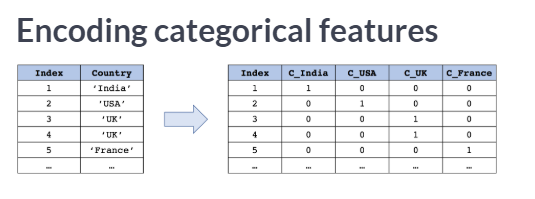

In [16]:
Image(filename='img/cat_feat_.png')

In doing that so the model can leverage the information of what country is given, without inferring any order between the different options. 

There are two main approaches when representing categorical columns in this way : 
- One-hot encoding
- Dummy encoding

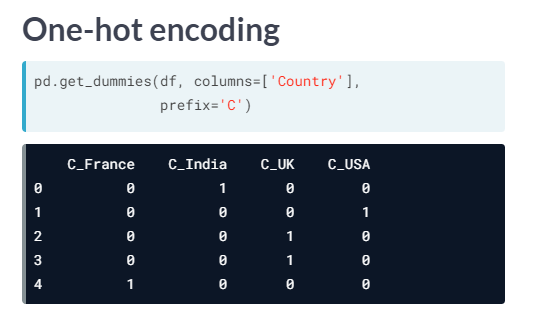

In [18]:
Image(filename='img/one_hot.png')

One-hot encoding converts n categories into n features as shown here. The function above takes a DataFrame and a list of categorical columns you want converted into one hot encoded columns, and returns an updated DataFrame with these columns included.  

In [50]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(label_X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(label_X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = label_X_train.index
OH_cols_valid.index = label_X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = label_X_train.drop(object_cols, axis=1)
num_X_valid = label_X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
0.22539009799854362


In [55]:
OH_X_train.head()

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4
PassengerId,,,,,,,,,,
141,3,28.0,0,2,15.2458,1.0,0.0,1.0,0.0,0.0
440,2,31.0,0,0,10.5000,0.0,1.0,0.0,0.0,1.0
818,2,31.0,1,1,37.0042,0.0,1.0,1.0,0.0,0.0
379,3,20.0,0,0,4.0125,0.0,1.0,1.0,0.0,0.0
492,3,21.0,0,0,7.2500,0.0,1.0,0.0,0.0,1.0


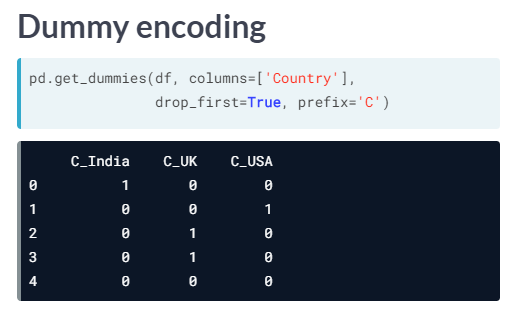

In [19]:
Image(filename='img/Dummy.png')

Dummy encoding creates n-1 features for n categories, omitting the first category. Notice that this time there is no feature for France, the first category. France in this case is encoded by the absence of all other countries as we can see on the last row in the figure above.

In [62]:
dummy_train = pd.get_dummies(X_train,drop_first=True)
dummy_valid = pd.get_dummies(X_valid,drop_first = True)
print("MAE from Approach 4 (dummy encoding):") 
print(score_dataset(dummy_train, dummy_valid, y_train, y_valid))

MAE from Approach 4 (dummy encoding):
0.22327914548116654


In [63]:
dummy_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
141,3,28.0,0,2,15.2458,0,0,0
440,2,31.0,0,0,10.5000,1,0,1
818,2,31.0,1,1,37.0042,1,0,0
379,3,20.0,0,0,4.0125,1,0,0
492,3,21.0,0,0,7.2500,1,0,1


#### 5 - Count Encoding 
Count encoding replaces each categorical value with the number of times it appears in the dataset. For example, if the value "GB" occured 10 times in the country feature, then each "GB" would be replaced with the number 10.

We'll use the categorical-encodings package to get this encoding. The encoder itself is available as CountEncoder. This encoder and the others in categorical-encodings work like scikit-learn transformers with .fit and .transform methods.

In [64]:
import category_encoders as ce
count_enc = ce.CountEncoder()


AttributeError: module 'category_encoders' has no attribute 'CountEncoder'

In [ ]:
count_encoded_train = count_enc.fit_transform(X_train[object_cols])
count_encoded_valid = count_enc.transform(X_valid[object_cols])
data = baseline_data.join(count_encoded.add_suffix("_count"))